<a href="https://colab.research.google.com/github/alekswheeler/global-_species_abundance_and_diversity/blob/main/AquecimentoGlobalEAbumdanciaDeEspecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

## Definição do problema

## Descrição do conjunto de dados

In [ ]:
pip install pygbif

Variáveis utilizadas na análise do artigo *“Estimating Extinction Risks with Species Occurrence Data from the Global Biodiversity Information Facility”* (Dasgupta, Blankespoor e Wheeler, 2024).  

As variáveis analisadas incluem:  

- **Espécies:**  
  - **species:** espécies com dados de ocorrência no GBIF.  
  - **d_assignedrisk:** indicação se a espécie está listada na Lista Vermelha da IUCN (1 para sim, 0 para não).  

- **Ameaças:** fatores que influenciam o risco de extinção, como:  
  - **parkpct:** índice de proteção formal, calculado com base na presença da espécie em áreas protegidas.  
  - **popdens:** densidade populacional, medida em um raster espacial dividido em 15 grupos.  
  - **eezpct:** percentual da área de ocorrência da espécie dentro de Zonas Econômicas Exclusivas (EEZ).  
  - **popshadow:** influência populacional costeira, baseada na projeção de dados terrestres sobre áreas marítimas.  
  - **totfishing:** intensidade total da pesca, estimada por monitoramento via satélite e sistemas AIS.  
  - **natfishing:** intensidade da pesca considerando impactos ambientais, calculada a partir de imagens de satélite.  
  - **pthreat:** índice de probabilidade de ameaça, variando de 0 a 100.  
  - **popgroupmax:** grupo máximo de densidade populacional, classificado em uma escala de 1 a 15.  

O estudo utiliza dados de diversas fontes, incluindo a IUCN, Global Fishing Watch e bases de dados espaciais, para estimar riscos de extinção com base na ocorrência das espécies.

Por conta do tamanho do conjunto de dados a importaçao é feita buscando o dado diretamente em algum serviço de armazenamento

In [3]:
import os
import zipfile
import requests

# 🔗 URL do Dropbox (modificada para permitir download direto)
dropbox_url = "https://www.dropbox.com/scl/fi/uanikg1a1jklpjyzl5j0x/global_biod_species_extinction_risks.zip?rlkey=fmb0q5n8tth1cvw9rt93a25n4&e=2&st=8iex1p7w&dl=1"

# 📂 Nome do arquivo ZIP localmente no Colab
zip_path = "dataset.zip"

# ⬇️ Baixa o arquivo ZIP do Dropbox
response = requests.get(dropbox_url)
with open(zip_path, "wb") as f:
    f.write(response.content)

print("✅ Download concluído!")

# 📂 Pasta de extração
extract_folder = "/content/dataset_csvs"
os.makedirs(extract_folder, exist_ok=True)

# 🔄 Extrai todos os arquivos CSV do ZIP
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

# 🔍 Lista os arquivos extraídos
csv_files = [f for f in os.listdir(extract_folder) if f.endswith(".csv")]

print("\n📂 Arquivos CSV extraídos:")
for file in csv_files:
    print(f"- {file}")

print("\n✅ Extração concluída! Todos os CSVs estão em:", extract_folder)


✅ Download concluído!

📂 Arquivos CSV extraídos:
- global_biod_species_extinction_risks.csv

✅ Extração concluída! Todos os CSVs estão em: /content/dataset_csvs


Como o conjunto original tem muitos dados, optamos por escolher aleatoriamente alguns dados do conjunto original para fazer a análise. Não é possível estratitificar essa escolha considerando a classe pois o conjunto original não tem essas informações apenas o ID de cada espécie.

In [4]:
import pandas as pd

SEED = 432

df = pd.read_csv("/content/dataset_csvs/global_biod_species_extinction_risks.csv")

df = df.sample(n=600, random_state=SEED)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 151876 to 239898
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   species         600 non-null    object 
 1   parkpct         600 non-null    float64
 2   popden          557 non-null    float64
 3   eezpct          184 non-null    float64
 4   popshadow       184 non-null    float64
 5   totfishing      184 non-null    float64
 6   natfishing      183 non-null    float64
 7   popgroupmax     591 non-null    float64
 8   pthreat         600 non-null    float64
 9   d_assignedrisk  600 non-null    float64
 10  lcat            600 non-null    object 
dtypes: float64(9), object(2)
memory usage: 56.2+ KB


Adicionando as features de Class, kingdom e [IUCNRedListCategory](https://en.wikipedia.org/wiki/IUCN_Red_List#Categories) que basicamente indica qual o estado de conservaçao das espécies.

- **Extinto (EX)** – para além de qualquer dúvida razoável de que a espécie já não existe.
- **Extinto na natureza (EW)** – sobrevive apenas em cativeiro, cultivo e/ou fora da área de distribuição nativa, como presumido após inquéritos exaustivos.
- **Criticamente ameaçada (CR)** – num estado particularmente e extremamente crítico.
- **Ameaçado (EN)** – risco muito elevado de extinção na natureza, satisfaz qualquer um dos critérios A a E para a extinção em perigo.
- **Vulnerável (VU)** – cumpre um dos 5 critérios da Lista Vermelha e, por conseguinte, é considerada como estando em elevado risco de extinção não natural (causada pelo homem) sem intervenção humana adicional.
- **Quase Ameaçado (NT)** – perto de estar em perigo num futuro próximo.
- **Menor Risco (LR)** – é improvável que se torne ameaçada ou extinta num futuro próximo.
- **Dados Deficientes (DD)**
- **Não Avaliado (NE)**

In [5]:
import requests
import pandas as pd

def get_species_info(scientific_name):
    url = f"https://api.gbif.org/v1/species/match?scientificName={scientific_name}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("usageKey"), data.get("class"), data.get("kingdom")
    else:
        print(f"Erro ao buscar dados para {scientific_name}: {response.status_code}")
        return None, None, None

def get_iucn_category(usage_key):
    url = f"https://api.gbif.org/v1/species/{usage_key}/iucnRedListCategory"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("category")
    else:
        print(f"Erro ao buscar categoria IUCN para usageKey {usage_key}: {response.status_code}")
        return None

def enrich_dataframe(df):
    df["Class"] = None
    df["Kingdom"] = None
    df["IUCNRedListCategory"] = None

    for index, row in df.iterrows():
        usage_key, class_name, kingdom = get_species_info(row["species"])
        df.at[index, "Class"] = class_name
        df.at[index, "Kingdom"] = kingdom

        if usage_key:
            iucn_category = get_iucn_category(usage_key)
            df.at[index, "IUCNRedListCategory"] = iucn_category

    return df

df = enrich_dataframe(df)

Erro ao buscar categoria IUCN para usageKey 4908866: 204
Erro ao buscar categoria IUCN para usageKey 2642861: 204
Erro ao buscar categoria IUCN para usageKey 1043590: 204


Como é possível ver no gráfico abaixo muitas espécies não possuem uma categoria definida. Além disso algumas das categorias podem ser agrupadas para facilitar o agrupamento.

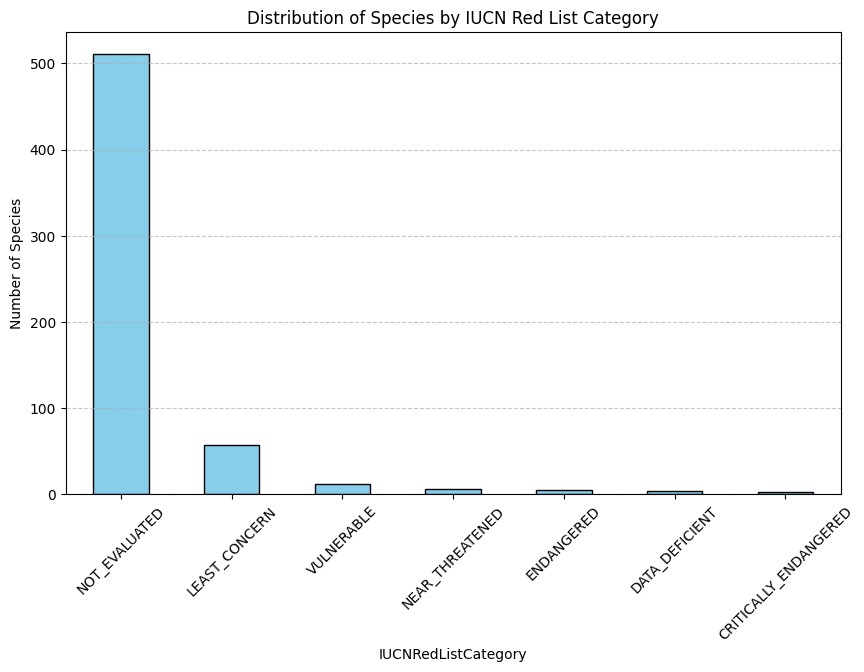

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_iucn_distribution(df, title, feature):
    plt.figure(figsize=(10, 6))
    df[feature].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel("Number of Species")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_iucn_distribution(df, "Distribution of Species by IUCN Red List Category", "IUCNRedListCategory")

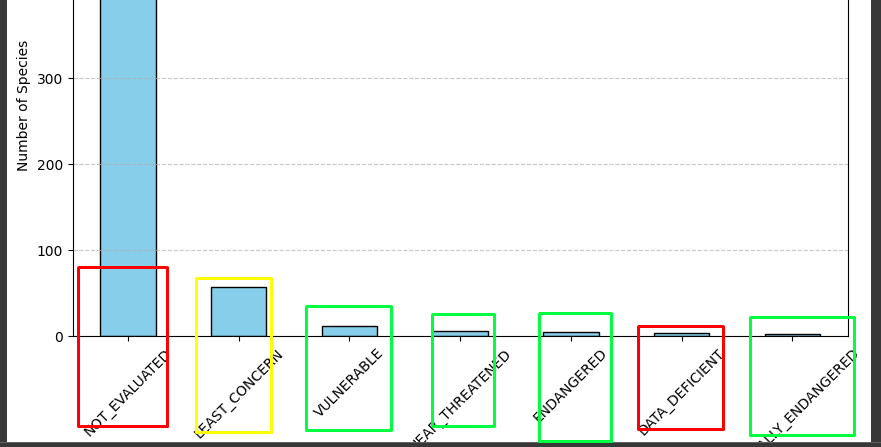

In [7]:
# import pandas as pd
# import requests
# import time
# from pygbif import species

# # def get_class_from_api(scientific_name):
# #     url = f"https://api.gbif.org/v1/species/match?scientificName={scientific_name}"
# #     response = requests.get(url)
# #     if response.status_code == 200:
# #         data = response.json()
# #         return data.get("class", "Unknown")
# #     return "Unknown"

# def get_class_from_pygbif(scientific_name):
#     result = species.name_backbone(name=scientific_name, verbose=False, strict=True, limit=2)
#     return result.get("class", "Unknown")

# def get_extinct_status(scientific_name):
#     result = species.name_lookup(q=scientific_name, verbose=False, limit=1)
#     if "results" in result and result["results"]:
#         return 1 if result["results"][0].get("extinct", False) else 0
#     return 0

# # Adicionando a coluna 'class' com os dados da API GBIF e pygbif
# df["class"] = df["species"].apply(lambda x: get_class_from_pygbif(x))

# # Adicionando a coluna 'extinct'
# df["extinct"] = df["species"].apply(lambda x: get_extinct_status(x))

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmap(df, x_feature, y_feature):
    """
    Gera um mapa de calor cruzando duas features categóricas.

    Parâmetros:
    - df: DataFrame do Pandas
    - x_feature: Nome da coluna a ser usada no eixo X
    - y_feature: Nome da coluna a ser usada no eixo Y
    """
    # Criando a tabela cruzada (contagem de ocorrências)
    heatmap_data = pd.crosstab(df[y_feature], df[x_feature])

    # Criando o mapa de calor
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt="d", linewidths=0.5)

    # Configurando os rótulos
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f"Mapa de Calor: {y_feature} vs {x_feature}")

    # Exibir o gráfico
    plt.show()


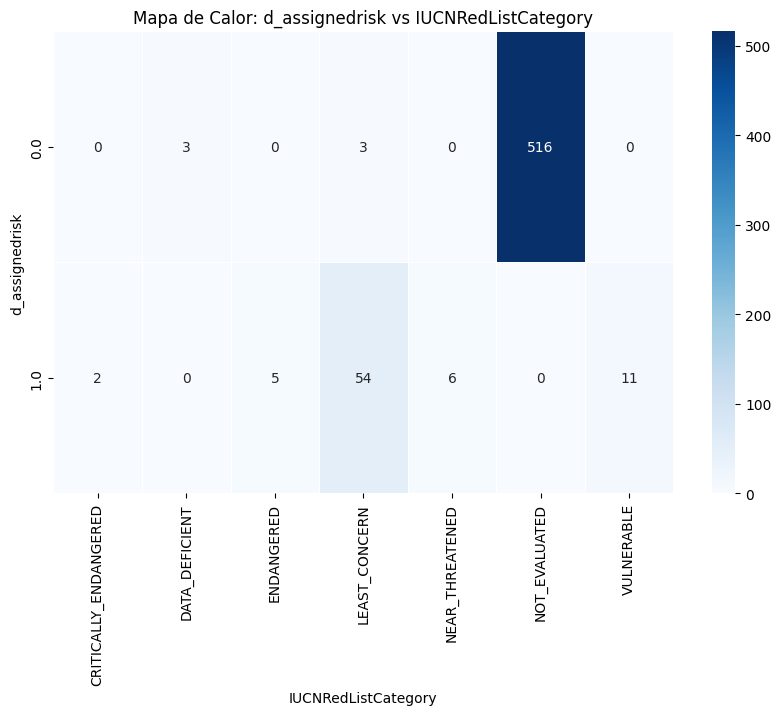

In [78]:
# plot_heatmap(df, "IUCNRedListCategory", "Kingdom")  # Mapa de calor entre categoria de risco e reino
plot_heatmap(df, "IUCNRedListCategory", "d_assignedrisk")  # Mapa de calor entre ameaça e categoria de risco

# Metodologia

## Pré processamento

- todo TRANSFORMAR VARIÁVEIS CATEGÓRICAS lcat
- TODO verificar a normalizaçao dos dados
- TODO Agrupar os targets [feito]

Algumas classes possuem pouquíssimos indivíduos, mas podem ser agrupadas pois todas representam espécies em risco. Aqui uma imagem mostrando a referência para o agrupamento.

In [37]:
df["IUCNRedListCategory"].unique()

array(['LEAST_CONCERN', 'NOT_EVALUATED', 'CRITICALLY_ENDANGERED',
       'ENDANGERED', 'NEAR_THREATENED', 'VULNERABLE', 'DATA_DEFICIENT'],
      dtype=object)

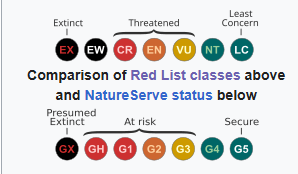

In [38]:
# Criando um dicionário de mapeamento
category_mapping = {
    "NOT_EVALUATED": "Unknown",
    "DATA_DEFICIENT": "Unknown",
    "LEAST_CONCERN": "Low Risk",
    "CRITICALLY_ENDANGERED": "Threatened",
    "ENDANGERED": "Threatened",
    "NEAR_THREATENED": "Threatened",
    "VULNERABLE": "Threatened"
}

# Aplicando o mapeamento
df["GroupedCategory"] = df["IUCNRedListCategory"].map(category_mapping)

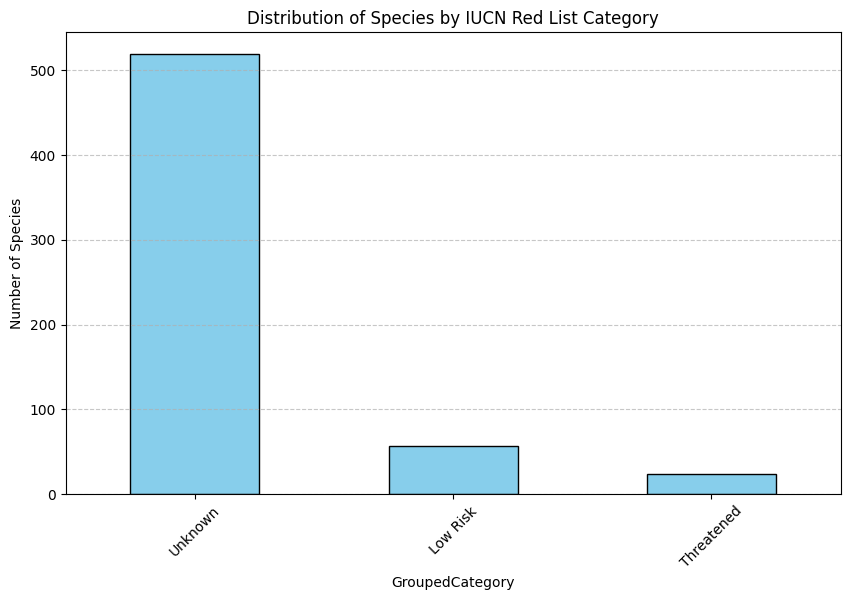

In [40]:
plot_iucn_distribution(df, "Distribution of Species by IUCN Red List Category", "GroupedCategory")

Vamos remover algumas colunas que possam causar viés nos classificadores. Por exemplo as colunas Kingdom e Class são apenas para fornecer uma visualizaçao melhor dos dados. E a coluna IUCNRedListCategory é o nosso Target.


In [41]:
df_species = df.copy()
df_species = df_species.drop(columns=['Class', 'Kingdom', 'IUCNRedListCategory','species', 'lcat', 'GroupedCategory'])

In [55]:
from sklearn.preprocessing import StandardScaler

# removendo NaN
# Lista das colunas numéricas com valores NaN
colunas_com_nan = ['parkpct', 'popden', 'eezpct', 'popshadow', 'totfishing',
                   'natfishing', 'popgroupmax', 'pthreat', 'd_assignedrisk']

# Preenchendo os NaN com a média da respectiva coluna
for coluna in colunas_com_nan:
    df_species[coluna] = df_species[coluna].fillna(df_species[coluna].mean())

# --- Normalizando os dados ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_species)

## Validaçao cruzada

In [57]:
from sklearn.preprocessing import LabelEncoder

# Criando um LabelEncoder
le = LabelEncoder()

df["GroupedCategory"] = df["GroupedCategory"].fillna("NOT_EVALUATED")
df["Risk"] = le.fit_transform(df["IUCNRedListCategory"])

X = df_species
y = df['Risk']

In [71]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Criando um classificador
clf = KMeans(random_state=33)
# Criando Stratified K-Fold para manter a proporção das classes
strat_kfold = RepeatedStratifiedKFold(n_splits=2, random_state=42)

# Definição dos hiperparâmetros a serem testados
param_grid = {
    "n_clusters": [3, 4, 5, 6, 7]
}

In [72]:
from sklearn.metrics import f1_score, make_scorer

# Criando um scorer personalizado para usar no GridSearchCV
f1_weighted_scorer = make_scorer(f1_score, average="weighted", zero_division=0)

# Criando o GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=strat_kfold, scoring=f1_weighted_scorer, n_jobs=-1)

# Treinando o modelo
grid_search.fit(X, y)

# Exibir os melhores parâmetros e resultado
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor F1-Score:", grid_search.best_score_)

Melhores parâmetros: {'n_clusters': 6}
Melhor F1-Score: 0.21242370186744552


## Visualização de dados

## Classificação

In [ ]:
# TESTE COM AGRUPAMENTO HIERÁRQUICO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering


# --- 1️⃣ Normalizando os dados ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_species)

# --- 2️⃣ Calculando a ligação e criando o Dendrograma ---
linked = linkage(df_scaled, method='ward')  # Método Ward

plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

# --- 3️⃣ Aplicando o Agrupamento Hierárquico Aglomerativo ---
# Defina o número de clusters desejado ou a distância de corte
n_clusters = 3  # Defina o número de clusters que você deseja

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_species['Cluster'] = agg_clustering.fit_predict(df_scaled)

# --- 4️⃣ Visualizando os Clusters ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_species['d_assignedrisk'], y=df_species['pthreat'], hue=df_species['Cluster'], palette='Set1', s=50)
plt.title('Agrupamento Hierárquico Aglomerativo')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Conclusão

## Discussãocação dos Resultados

# Video


Um vídeo (de aproximadamente 5 minutos) descrevendo o trabalho e os resultados. Pretendo divulgar esse vídeo para os demais colegas da disciplina e para os professores do DI. **Os vídeos são apenas para facilitar a correção e não serão publicados!**

# Referências

https://techdocs.gbif.org/en/openapi/

https://datacatalog.worldbank.org/search/dataset/0066034/Global-Biodiversity-Data